## Example Operations of FMOps

The purpose of this notebook is to illustrate the capabilities SageMaker AI and Managed MLflow on SageMaker AI for FMOps tasks. In this notebook, we cover the foundational capabilities needed to develop an automated LLM fine-tuning and evaluation pipeline. We cover these components individually, without an orchestration service, to showcase the capabilities atomically. This notebook lays the groundwork for the next notebook, which stiches together these disparate components into a fully orchestrated fine-tuning and model evaluation pipeline powered by SageMaker AI Pipelines and Managed MLflow on SageMaker AI.

## Prerequisites 
Before you begin, make sure you have the following prerequisites in place:

- MLflow tracking server: If you're running this lab in a workshop environment, a MLflow tracking server has already been created for you. If you need to create a MLflow tracking server, follow the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/mlflow-create-tracking-server.html)

### 1. Setup and Dependencies
Install dependencies and configure kernel.

Restart the kernel after executing below cells.

In [10]:
%pip install -r ./scripts/requirements.txt --upgrade --quiet

Note: you may need to restart the kernel to use updated packages.


In [11]:
from IPython import get_ipython
get_ipython().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

**Importing Libraries and Setting Up Environment**

This part imports all necessary Python modules. It includes SageMaker-specific imports for pipeline creation and execution, which will be used to define the pipeline steps.

In [2]:
import os
import json
import time
import uuid
import boto3
import mlflow
import tarfile
import botocore
import traceback

from tqdm import tqdm
from datetime import datetime
from sagemaker.core.resources import Model, Endpoint, EndpointConfig
from sagemaker.core.shapes import ContainerDefinition, ProductionVariant
from sagemaker.core.helper.session_helper import Session, get_execution_role, _wait_until, _deploy_done
from sagemaker.core.common_utils import name_from_base

### 2. SageMaker Session and IAM Role

`get_execution_role()`: Retrieves the IAM role that SageMaker will use to access AWS resources. This role needs appropriate permissions for tasks like accessing S3 buckets and creating SageMaker resources.

If you are running this lab in a workshop environment, the execution role will have the appropriate permissions necessary to execute the following tasks. If not, you may need to check the permissions attached to your sagemaker execution role.

In [3]:
sagemaker_session = Session()
role = get_execution_role(sagemaker_session, use_default=True)
region = sagemaker_session.boto_session.region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


### 3. Configuration
Here we setup our example execution environment.

We define appropriate paths in S3 to store model files, define the model we will be working with, and define the model endpoint name.

In this lab, we are working with [Qwen3-4B-Instruct-2507](https://huggingface.co/Qwen/Qwen3-4B-Instruct-2507). It is easy to fine-tune as we will see in the next lab, and is small enough to fit on a reasonably sized GPU-accelerated hosting endpoint.

In [4]:
bucket_name = sagemaker_session.default_bucket()
print(bucket_name)
default_prefix = sagemaker_session.default_bucket_prefix
if default_prefix:
    input_path = f'{default_prefix}/datasets/llm-fine-tuning-modeltrainer-sft'
else:
    input_path = f'datasets/llm-fine-tuning-modeltrainer-sft'

sagemaker-us-west-2-143709572556


In [5]:
model_id = "Qwen/Qwen3-4B-Instruct-2507"
model_id_filesafe = model_id.replace("/","_").replace(".", "_")
model_name_safe = model_id.split('/')[-1].replace('.', '-').replace('_', '-')
endpoint_name = f"Example-{model_name_safe}"
instance_count = 1
instance_type = "ml.g5.2xlarge"
health_check_timeout = 1800
data_download_timeout = 3600

MLflow integration is crucial for experiment tracking and management. 

**Update the ARN for the MLflow tracking server.**

This example requires a SageMaker with MLflow tracking server to track experiments and manage model artifacts. To create your own tracking server please refer to the [SageMaker documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/mlflow-create-tracking-server.html). Once you have created your tracking server, please copy the tracking server ARN to the `mlflow_tracking server_arn` variable in the cell below.

In [6]:
mlflow_tracking_server_arn = "arn:aws:sagemaker:us-west-2:143709572556:mlflow-app/app-F5XVW7RQGBFO"

try:
    response = boto3.client('sagemaker').describe_mlflow_tracking_server(
        TrackingServerName='genai-mlflow-tracker'
    )
    mlflow_tracking_server_arn = response['TrackingServerArn']
    print(f"MLflow Tracking Server ARN: {mlflow_tracking_server_arn}")
except botocore.exceptions.ClientError:
    print("No MLflow Tracking Server Found, please input a value for mlflow_tracking_server_arn")

os.environ["mlflow_tracking_server_arn"] = mlflow_tracking_server_arn

No MLflow Tracking Server Found, please input a value for mlflow_tracking_server_arn


### 4. Model Deployment
There are several approaches to deploying a model to a SageMaker AI managed endpoint. In this section, we explore the most direct option which downloads a model directly from HuggingFace to the managed endpoint via SageMaker JumpStart. We are still using Qwen3-4B-Instruct-2507, but we have not fine-tuned it. The purpose of this section is to illustrate the components required to customize a model deployment on SageMaker before fine-tuning it.

![](./Task5-Deploy.png)

#### Image URI
By default, images downloaded from HuggingFace use the [Text Generation Inference](https://huggingface.co/docs/text-generation-inference/en/index) model serving toolkit. 

For this lab, we want to change the underlying model server to [Deep Java Library's Large Model Inference](https://docs.djl.ai/master/docs/serving/serving/docs/lmi/index.html) container, or DJL-LMI. This serving container offers [several performance benefits](https://aws.amazon.com/blogs/machine-learning/supercharge-your-llm-performance-with-amazon-sagemaker-large-model-inference-container-v15/) that we want to leverage for the production deployment.

In [7]:
inference_image_uri = f"763104351884.dkr.ecr.{region}.amazonaws.com/djl-inference:0.33.0-lmi15.0.0-cu128"
print(f"using image to host: {inference_image_uri}")

using image to host: 763104351884.dkr.ecr.us-west-2.amazonaws.com/djl-inference:0.33.0-lmi15.0.0-cu128


#### HuggingFace + SageMaker JumpStart
Here we download the model from SageMaker Jumpstart and create a `HuggingFaceModel` object. Notice how we define the `model_id` in the configuration, and specify the `image_uri` defined above in the instantiation of the model object.

In [8]:
model_config = {
    'HF_MODEL_ID': model_id,
    'SM_NUM_GPUS': json.dumps(1),
    'OPTION_TRUST_REMOTE_CODE': 'true',
    'OPTION_ROLLING_BATCH': "vllm",
    'OPTION_DTYPE': 'bf16',
    'OPTION_QUANTIZE': 'fp8',
    'OPTION_TENSOR_PARALLEL_DEGREE': 'max',
    'OPTION_MAX_ROLLING_BATCH_SIZE': '32',
    'OPTION_MODEL_LOADING_TIMEOUT': '3600',
    'OPTION_MAX_MODEL_LEN': '4096'
}
# Model will be created during deployment below

#### Model Deploy w/Managed MLFlow 3.0 on SageMaker AI
Now we stitch the pieces together and use MLFlow to orchestrate the deployment of our model to a SageMaker AI managed endpoint.

In [9]:
# Initialize MLFlow tracking data...
mlflow.set_tracking_uri(mlflow_tracking_server_arn)
mlflow.set_experiment("Default")

<Experiment: artifact_location='s3://my-mlflow-artifacts-1770841365/0', creation_time=1770841656264, experiment_id='0', last_update_time=1770841656264, lifecycle_stage='active', name='Default', tags={}>

In [12]:
with mlflow.start_run(run_name="example_model_deployment_new"):
    deployment_start_time = time.time()

    mlflow.log_params({
        "model_id": model_id,
        "instance_type": instance_type,
        "instance_count": instance_count,
        "endpoint_name": endpoint_name,
        "health_check_timeout": health_check_timeout,
        "data_download_timeout": data_download_timeout
    })
    mlflow.log_params({"model_config_" + k: v for k, v in model_config.items()})

    try:
        deploy_model_name = name_from_base("fmops-model")
        core_model = Model.create(
            model_name=deploy_model_name,
            execution_role_arn=role,
            primary_container=ContainerDefinition(
                image=inference_image_uri,
                environment=model_config,
            ),
        )

        EndpointConfig.create(
            endpoint_config_name=endpoint_name+"v3",
            production_variants=[
                ProductionVariant(
                    variant_name="AllTraffic",
                    model_name=deploy_model_name,
                    initial_instance_count=instance_count,
                    instance_type=instance_type,
                    container_startup_health_check_timeout_in_seconds=health_check_timeout,
                    model_data_download_timeout_in_seconds=data_download_timeout,
                )
            ],
        )

        core_endpoint = Endpoint.create(
            endpoint_name=endpoint_name,
            endpoint_config_name=endpoint_name,
        )

        _wait_until(lambda: _deploy_done(sagemaker_session.sagemaker_client, endpoint_name), poll=30)

        deployment_time = time.time() - deployment_start_time
        mlflow.log_metric("deployment_time_seconds", deployment_time)
        mlflow.log_metric("deployment_success", 1)

        mlflow.set_tags({
            "endpoint_status": "deployed",
            "deployment_type": "sagemaker",
            "framework": "djl-lmi"
        })

    except Exception as e:
        mlflow.log_metric("deployment_success", 0)
        mlflow.log_param("error_message", str(e))
        mlflow.set_tag("endpoint_status", "failed")
        raise e

[02/13/26 20:19:11] INFO     Creating model resource.                                            ]8;id=515347;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=987395;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#22771\22771]8;;\

                    INFO     Creating endpoint_config resource.                                  ]8;id=908271;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=817499;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#11602\11602]8;;\

[02/13/26 20:19:12] INFO     Creating endpoint resource.                                         ]8;id=747316;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=653927;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#10735\10735]8;;\

----------------------!🏃 View run example_model_deployment_new at: https://mlflow.sagemaker.us-west-2.app.aws/#/experiments/0/runs/f2a74f75080445e8a4c78fe180dc7c96
🧪 View experiment at: https://mlflow.sagemaker.us-west-2.app.aws/#/experiments/0


#### Test Model Prediction
Now we stitch the pieces together and use MLFlow to orchestrate the deployment of our model to a SageMaker AI managed endpoint.

In [13]:
core_endpoint = Endpoint.get(endpoint_name=endpoint_name)

response = core_endpoint.invoke(
    body=json.dumps({
        "messages": [
            {"role": "user", "content": "Hi, what can you help me with?"}
        ],
        "parameters": {
            "max_new_tokens": 512,
            "top_p": 0.9,
            "temperature": 0.6,
            "return_full_text": False
        }
    }),
    content_type="application/json",
    accept="application/json",
)

result = json.loads(response.body.read().decode("utf-8"))
result

{'id': 'chatcmpl-140257728008784',
 'object': 'chat.completion',
 'created': 1771014647,
 'choices': [{'index': 0,
   'message': {'role': 'assistant',
    'content': "Hi! I'm here to help with all sorts of things — whether it's answering questions, solving problems, writing content, coding, planning, or just chatting. What would you like to work on today? 😊"},
   'logprobs': None,
   'finish_reason': 'eos_token'}],
 'usage': {'prompt_tokens': 17, 'completion_tokens': 45, 'total_tokens': 62}}

In [14]:
def create_guardrail():
    # Guardrail doesn't exist, create it
    try:
        guardrail = guardrail_client.create_guardrail(
            name="ExampleMedicalGuardrail",
            description='Example of a Guardrail for Medical Use Cases',
            topicPolicyConfig={
                'topicsConfig': [{
                    'name': 'Block Pharmaceuticals',
                    'definition': 'This model cannot recommend one pharmaceutical over another. Generic prescriptions consistent with medical expertise and clinical diagnoses only.',
                    'type': 'DENY',
                    'inputAction': 'BLOCK',
                    'outputAction': 'BLOCK',
                }]        
            },
            sensitiveInformationPolicyConfig={
                'piiEntitiesConfig': [
                    {
                        'type': 'UK_NATIONAL_HEALTH_SERVICE_NUMBER',
                        'action': 'BLOCK',
                        'inputAction': 'BLOCK',
                        'outputAction': 'BLOCK'
                    },
                ]
            },
            contextualGroundingPolicyConfig={
                'filtersConfig': [
                    {
                        'type': 'RELEVANCE',
                        'threshold': 0.9,
                        'action': 'BLOCK',
                        'enabled': True
                    },
                ]
            },
            blockedInputMessaging="ExampleMedicalGuardrail has blocked this input.",
            blockedOutputsMessaging="ExampleMedicalGuardrail has blocked this output."
        )
        guardrail_id = guardrail['guardrailId']
        guardrail_version = guardrail['version']
        
        print(f"Created new guardrail '{guardrail_id}:{guardrail_version}'")
        return guardrail_id, guardrail_version
    except botocore.exceptions.ClientError as create_error:
        print(f"Error creating guardrail: {create_error}")

In [15]:
guardrail_client = boto3.client('bedrock')
guardrail_name = "ExampleMedicalGuardrail"
try:
    # Try to get the guardrail
    response = guardrail_client.list_guardrails()
    guardrail_id = ""
    for guardrail in response.get('guardrails', []):
        if guardrail['name'] == guardrail_name:
            guardrail_id = guardrail['id']
    if guardrail_id != "":
        response = guardrail_client.get_guardrail(
            guardrailIdentifier=guardrail_id
        )
        guardrail_version = response["version"]
        print(f"Found Guardrail {guardrail_id}:{guardrail_version}")
    else:
        guardrail_id, guardrail_version = create_guardrail()
except botocore.exceptions.ClientError as e:
    print(f"Error checking guardrail: {e}")

Created new guardrail '81wm8cxswfqs:DRAFT'


In [16]:
bedrock_runtime = boto3.client('bedrock-runtime')

### 5. Qualitative Model Evaluation
Let's test the default Qwen3-4B-Instruct-2507 using MLFlow's LLM-as-a-Judge capability. We'll use [Anthropic's Claude Sonnet 4](https://www.anthropic.com/news/claude-4) model on [Amazon Bedrock](https://aws.amazon.com/bedrock/) as the judge. We'll also wrap our model endpoint invocation in a method making it easier to call in the evaluation. 

This particular endpoint is the [global cross-region inference endpoint](https://docs.aws.amazon.com/bedrock/latest/userguide/cross-region-inference.html) name for Claude Sonnet 4.

Wrapping our invocation in a separate method allows us to trace evaluation calls to the model using the `@mlflow.trace` annotation. These traces will appear in our MLFlow experiment under the "Traces" tab.

![](Task5-Evaluate.png)

In [17]:
# judge_llm = "bedrock:/anthropic.claude-3-haiku-20240307-v1:0"
judge_llm = "bedrock:/global.anthropic.claude-sonnet-4-20250514-v1:0"

In [18]:
from mlflow.entities import SpanType

@mlflow.trace(
    name="call-local-llm", span_type=SpanType.LLM, attributes={
        "model": model_id,
        "guardrail_id": guardrail_id,
        "guardrail_version": guardrail_version
    }
)
def invoke_sagemaker_endpoint(payload):

    print(payload)

    guardrail_response_input = bedrock_runtime.apply_guardrail(
        guardrailIdentifier=guardrail_id,
        guardrailVersion=guardrail_version,
        source='INPUT',
        content=[{'text': {'text': payload["messages"][0]["content"]}}]
    )
    guardrailResult = guardrail_response_input["action"]

    if guardrailResult == "GUARDRAIL_INTERVENED":
        reason = guardrail_response_input["assessments"]
        print(f"Guardrail intervention: {reason}")
        return guardrail_response_input["outputs"][0]["text"], -1
    
    try:
        start_time = time.time()
        ep = Endpoint.get(endpoint_name=endpoint_name)
        resp = ep.invoke(
            body=json.dumps(payload),
            content_type="application/json",
            accept="application/json",
        )
        response = json.loads(resp.body.read().decode("utf-8"))
        inference_time = time.time() - start_time
        return response, inference_time
    except Exception as e:
        print(f"Error invoking endpoint {endpoint_name}: {str(e)}")
        return None, -1

Now use Managed MLFlow 3.0 on Amazon SageMaker AI's `EvaluationExample` object to provide examples of good and bad model responses. This synthetic data will be used to evaluate our Example Qwen3-4B-Instruct-2507 along with several qualitative metrics. We create these qualitative metrics using `make_genai_metric`.

In [19]:
from mlflow.metrics.genai import EvaluationExample, make_genai_metric

medical_accuracy_examples = [
    EvaluationExample(
        input="What is the first-line treatment for hypertension?",
        output="ACE inhibitors or thiazide diuretics are typically first-line treatments for hypertension.",
        score=4,
        justification="The response correctly identifies evidence-based first-line treatments for hypertension."
    ),
    EvaluationExample(
        input="What causes Type 1 diabetes?",
        output="Type 1 diabetes is caused by autoimmune destruction of pancreatic beta cells.",
        score=5,
        justification="Accurate and concise explanation of Type 1 diabetes pathophysiology."
    ),
    EvaluationExample(
        input="How do you treat a heart attack?",
        output="You should take aspirin and call emergency services immediately.",
        score=2,
        justification="While partially correct, this oversimplifies emergency treatment and misses critical interventions."
    )
]

medical_accuracy = make_genai_metric(
    name="medical_accuracy",
    definition=(
        "Medical accuracy measures how factually correct and evidence-based the medical information is. "
        "Consider current medical guidelines, evidence-based practice, and clinical accuracy. "
        "Score 1-5 where 5 is completely accurate and evidence-based."
    ),
    grading_prompt=(
        "Evaluate the medical accuracy of the response on a scale of 1-5:\n"
        "5: Completely accurate, evidence-based, follows current medical guidelines\n"
        "4: Mostly accurate with minor gaps or generalizations\n"
        "3: Generally accurate but missing important details or context\n"
        "2: Partially accurate but contains some medical inaccuracies\n"
        "1: Contains significant medical errors or misinformation\n\n"
        "Question: {input}\n"
        "Response: {output}\n\n"
        "Consider: Is the medical information factually correct? Does it align with current evidence-based practice? "
        "Are there any dangerous inaccuracies or omissions?\n\n"
        "Provide your score as a single integer from 1-5."
    ),
    examples=medical_accuracy_examples,
    version="v1",
    model=judge_llm,
    parameters={
        "anthropic_version": "bedrock-2023-05-31",
        "temperature": 0.0,
        "max_tokens": 1000
    },
    aggregations=["mean", "variance", "p90"],
    greater_is_better=True
)

# Clinical Reasoning Metric
clinical_reasoning_examples = [
    EvaluationExample(
        input="A 65-year-old man presents with chest pain. What should be considered?",
        output="Given the patient's age and presentation, we should immediately consider cardiac causes like myocardial infarction, unstable angina, and aortic dissection. The approach should include ECG, cardiac enzymes, chest X-ray, and careful history taking about pain characteristics, onset, and associated symptoms.",
        score=5,
        justification="Excellent clinical reasoning with systematic approach, appropriate differential diagnosis, and logical diagnostic workup."
    ),
    EvaluationExample(
        input="Patient has fever and cough. What's the diagnosis?",
        output="The patient has pneumonia and needs antibiotics.",
        score=2,
        justification="Poor reasoning - jumps to conclusion without proper assessment, history, or consideration of differential diagnosis."
    )
]

clinical_reasoning = make_genai_metric(
    name="clinical_reasoning",
    definition=(
        "Clinical reasoning evaluates the logical thought process, differential diagnosis consideration, "
        "and systematic approach to medical problems. Assesses whether the response demonstrates "
        "appropriate medical decision-making skills."
    ),
    grading_prompt=(
        "Evaluate the clinical reasoning quality on a scale of 1-5:\n"
        "5: Excellent reasoning with systematic approach, appropriate differential diagnosis, logical steps\n"
        "4: Good reasoning with mostly sound logic and appropriate considerations\n"
        "3: Adequate reasoning but may miss some important considerations\n"
        "2: Poor reasoning with significant logical gaps or inappropriate approach\n"
        "1: No clear reasoning or completely inappropriate approach\n\n"
        "Question: {input}\n"
        "Response: {output}\n\n"
        "Consider: Does the response show logical thinking? Are differential diagnoses considered? "
        "Is the approach systematic and appropriate for the clinical scenario?\n\n"
        "Provide your score as a single integer from 1-5."
    ),
    examples=clinical_reasoning_examples,
    version="v1",
    model=judge_llm,
    parameters={
        "anthropic_version": "bedrock-2023-05-31",
        "temperature": 0.0,
        "max_tokens": 1000
    },
    aggregations=["mean", "variance", "p90"],
    greater_is_better=True
)

# Patient Safety Metric
patient_safety_examples = [
    EvaluationExample(
        input="Patient allergic to penicillin needs antibiotic. What do you recommend?",
        output="Since the patient is allergic to penicillin, I would recommend alternative antibiotics such as macrolides (azithromycin), cephalosporins (if no cross-reactivity), or fluoroquinolones, depending on the specific infection and patient factors.",
        score=5,
        justification="Excellent safety awareness - acknowledges allergy and provides appropriate alternatives."
    ),
    EvaluationExample(
        input="Patient with chest pain asks if they can drive home.",
        output="Sure, if you're feeling better you can drive home.",
        score=1,
        justification="Dangerous advice - patient with chest pain should not drive and needs immediate medical evaluation."
    )
]

patient_safety = make_genai_metric(
    name="patient_safety",
    definition=(
        "Patient safety measures whether the response prioritizes patient wellbeing, avoids harmful advice, "
        "considers contraindications, and promotes safe medical practices."
    ),
    grading_prompt=(
        "Evaluate patient safety considerations on a scale of 1-5:\n"
        "5: Prioritizes safety, considers contraindications, promotes safe practices\n"
        "4: Generally safe with minor safety considerations\n"
        "3: Mostly safe but may miss some safety considerations\n"
        "2: Some safety concerns or inappropriate advice\n"
        "1: Potentially dangerous advice or significant safety issues\n\n"
        "Question: {input}\n"
        "Response: {output}\n\n"
        "Consider: Is the advice safe? Are contraindications considered? Could following this advice harm the patient?\n\n"
        "Provide your score as a single integer from 1-5."
    ),
    examples=patient_safety_examples,
    version="v1",
    model=judge_llm,
    parameters={
        "anthropic_version": "bedrock-2023-05-31",
        "temperature": 0.0,
        "max_tokens": 1000
    },
    aggregations=["mean", "variance", "p90"],
    greater_is_better=True
)

bedrock_judge_metrics = [medical_accuracy, clinical_reasoning, patient_safety]

/tmp/ipykernel_83948/1214023900.py:24: FutureWarning: ``mlflow.metrics.genai.genai_metric.make_genai_metric`` is deprecated since 3.4.0. Use the new GenAI evaluation functionality instead. See https://mlflow.org/docs/latest/genai/eval-monitor/legacy-llm-evaluation/ for the migration guide.
  medical_accuracy = make_genai_metric(
/tmp/ipykernel_83948/1214023900.py:72: FutureWarning: ``mlflow.metrics.genai.genai_metric.make_genai_metric`` is deprecated since 3.4.0. Use the new GenAI evaluation functionality instead. See https://mlflow.org/docs/latest/genai/eval-monitor/legacy-llm-evaluation/ for the migration guide.
  clinical_reasoning = make_genai_metric(
/tmp/ipykernel_83948/1214023900.py:120: FutureWarning: ``mlflow.metrics.genai.genai_metric.make_genai_metric`` is deprecated since 3.4.0. Use the new GenAI evaluation functionality instead. See https://mlflow.org/docs/latest/genai/eval-monitor/legacy-llm-evaluation/ for the migration guide.
  patient_safety = make_genai_metric(


This method performs the qualitative evaluation using `mlflow.evaluate`. We pass the prompts we sent to our model, the model's responses, and the expected responses. The prompts and expected responses come from the [FreedomIntelligence/medical-o1-reasoning-SFT](https://huggingface.co/datasets/FreedomIntelligence/medical-o1-reasoning-SFT) dataset, available on HuggingFace. 

Our model's responses are compared to the expected responses and evaluated using the `EvaluationExample` objects and the grading prompt to determine the qualitative performance of this model.

In [20]:
def evaluate_model_qualitatively(model_config, dataset):
    import time
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    """
    Evaluate a fine-tuned model using LLM-as-a-judge metrics with fallback.
    """
    model_name = model_config["name"]
    endpoint_name = model_config["endpoint"]
    
    print(f"\nPerforming qualitative evaluation for model: {model_name} on endpoint: {endpoint_name}")
    
    predictions = []
    questions = []
    references = []
    inference_times = []
    failed_generations = 0
    metric_results = {}
    
    for example in tqdm(dataset, desc="Generating responses for evaluation"):
        question = example["Question"]
        reference = "\n".join([example["Complex_CoT"], example["Response"]])
        
        
        payload = {
            "messages": [
                {"role": "user", "content": question}
            ],
            "parameters": {
                "max_new_tokens": 512,
                "top_p": 0.9,
                "temperature": 0.6,
                "return_full_text": False
            }
        }
        
        # Call the model endpoint
        try:
            response, inference_time = invoke_sagemaker_endpoint(payload)
            
            if response is None:
                prediction = "Error generating response."
                failed_generations += 1
            elif isinstance(response, list):
                prediction = response[0].get('generated_text', '').strip()
            elif isinstance(response, dict):
                prediction = response.get('generated_text', '').strip()
            else:
                prediction = str(response).strip()
            
            prediction = prediction.split("<|eot_id|>")[0] if "<|eot_id|>" in prediction else prediction
            inference_times.append(inference_time)
            
        except Exception as e:
            print(f"Error invoking SageMaker endpoint {endpoint_name}: {e}")
            prediction = "Error generating response."
            failed_generations += 1
            inference_times.append(-1)
        
        predictions.append(prediction)
        questions.append(question)
        references.append(reference)
    
    # Log basic generation metrics
    mlflow.log_metric("qualitative_failed_generations", failed_generations)
    mlflow.log_metric("qualitative_failure_rate", failed_generations / len(dataset) if len(dataset) > 0 else 0)
    
    # LLM-as-a-judge evaluation
    try:
        print("Attempting LLM-as-a-judge evaluation using AWS Bedrock...")
        
        # Prepare data for MLflow evaluation
        eval_data = pd.DataFrame({
            "inputs": questions,
            "outputs": predictions,
            "targets": references
        })
        
        # Run MLflow evaluation
        eval_results = mlflow.evaluate(
            data=eval_data,
            targets="targets",
            predictions="outputs",
            extra_metrics=bedrock_judge_metrics,
        )
        print(f"Raw evaluation results: {eval_results.metrics}")
        
        # Extract metric results
        for metric_name in ["medical_accuracy/v1/mean", "clinical_reasoning/v1/mean", "patient_safety/v1/mean"]:
            if metric_name in eval_results.metrics:
                base_name = metric_name.split('/')[0]
                metric_results[base_name] = eval_results.metrics[metric_name]
                if not np.isnan(metric_results[base_name]):
                    mlflow.log_metric(f"qualitative_{base_name}", metric_results[base_name])
                else: 
                    mlflow.log_metric(f"qualitative_{base_name}", 0.0)
        
        print("LLM-as-a-judge evaluation completed successfully!")
        # time.sleep(10)
        
    except Exception as e:
        print(f"LLM-as-a-judge evaluation failed: {str(e)}")
       
    # Create evaluation summary
    evaluation_details = []
    for i, (pred, question, ref) in enumerate(zip(predictions[:5], questions[:5], references[:5])):
        evaluation_details.append({
            "question": question,
            "prediction": pred[:500] + ("..." if len(pred) > 500 else ""),
            "reference": ref[:500] + ("..." if len(ref) > 500 else ""),
        })
    
    # Save detailed results
    detailed_df = pd.DataFrame(evaluation_details)
    temp_csv = f"/tmp/qualitative_eval_detailed_{uuid.uuid4().hex[:8]}.csv"
    detailed_df.to_csv(temp_csv, index=False)
    mlflow.log_artifact(temp_csv, "qualitative_evaluation")
    
    # Create simple visualization
    plt.figure(figsize=(10, 6))
    metric_names = list(metric_results.keys())
    metric_values = list(metric_results.values())
    plt.bar(metric_names, metric_values, color=['blue', 'green', 'red', 'orange'])
    plt.title('Qualitative Evaluation Scores')
    plt.ylabel('Score (1-5)')
    plt.ylim(1, 5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('/tmp/qualitative_metrics.png', dpi=300, bbox_inches='tight')
    mlflow.log_artifact('/tmp/qualitative_metrics.png', "qualitative_evaluation")
    
    avg_medical_accuracy = metric_results.get("medical_accuracy", metric_results.get("overall_quality", 3.0))
    
    return {
        "model_name": model_name,
        "endpoint_name": endpoint_name, 
        "num_samples": len(dataset),
        "metrics": metric_results,
        "evaluation_details": evaluation_details,
        "avg_medical_accuracy": avg_medical_accuracy
    }

Here we initialize the MLFlow run. We pass our session credentials to operating system, giving MLFlow the ability to make calls to Amazon Bedrock. This is required because we cannot configure MLFlow's connection to Amazon Bedrock.

[02/13/26 20:31:45] INFO     PyTorch version 2.6.0 available.                                          ]8;id=173079;file:///opt/conda/lib/python3.12/site-packages/datasets/config.py\config.py]8;;\:]8;id=1952;file:///opt/conda/lib/python3.12/site-packages/datasets/config.py#54\54]8;;\

                    INFO     Duckdb version 1.4.3 available.                                           ]8;id=860176;file:///opt/conda/lib/python3.12/site-packages/datasets/config.py\config.py]8;;\:]8;id=497300;file:///opt/conda/lib/python3.12/site-packages/datasets/config.py#77\77]8;;\

                    INFO     TensorFlow version 2.18.0 available.                                     ]8;id=843519;file:///opt/conda/lib/python3.12/site-packages/datasets/config.py\config.py]8;;\:]8;id=245472;file:///opt/conda/lib/python3.12/site-packages/datasets/config.py#112\112]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=250642;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=126804;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=666941;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=588575;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=419272;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=192314;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=53377;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=856067;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=717655;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=989585;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

Loaded medical-o1-reasoning dataset with 10 samples for qualitative evaluation


[02/13/26 20:31:47] INFO     Found credentials in environment variables.                        ]8;id=953935;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=417854;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=793174;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=406929;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\


Performing qualitative evaluation for model: Example-Qwen3-4B-Instruct-2507-sft-djl on endpoint: Example-Qwen3-4B-Instruct-2507-sft-djl


Generating responses for evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

{'messages': [{'role': 'user', 'content': 'A 67-year-old male with a past medical history of diabetes type II, obesity, and hyperlipidemia presents to the general medical clinic with bilateral hearing loss. He also reports new onset vertigo and ataxia. The symptoms started a day after undergoing an uncomplicated cholecystectomy. If a drug given prophylactically just prior to surgery has caused this patient’s symptoms, what is the mechanism of action of the drug?\nA. Inhibition of the formation of the translation initiation complex\nB. Inhibition of DNA-dependent RNA polymerase\nC. Inhibition of cell wall synthesis\nD. Inhibition of DNA gyrase\nE. Formation of free radical toxic metabolites that damage DNA'}], 'parameters': {'max_new_tokens': 512, 'top_p': 0.9, 'temperature': 0.6, 'return_full_text': False}}


[02/13/26 20:32:03] INFO     Found credentials in environment variables.                        ]8;id=715924;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=941887;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=664338;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=342488;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=197166;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=24968;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

Generating responses for evaluation:  10%|█         | 1/10 [00:15<02:19, 15.48s/it]

{'messages': [{'role': 'user', 'content': 'A 15-year-old boy died suddenly while playing in the field, and an autopsy revealed fibrofatty replacement of the right ventricular myocardium. What is the most likely diagnosis?'}], 'parameters': {'max_new_tokens': 512, 'top_p': 0.9, 'temperature': 0.6, 'return_full_text': False}}


[02/13/26 20:32:09] INFO     Found credentials in environment variables.                        ]8;id=312155;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=981518;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=875888;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=328996;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

Generating responses for evaluation:  20%|██        | 2/10 [00:21<01:19,  9.97s/it]

{'messages': [{'role': 'user', 'content': 'According to the IAP classification of Grade IV malnutrition, what is the percentage of the weight-for-age of the standard that defines this grade?'}], 'parameters': {'max_new_tokens': 512, 'top_p': 0.9, 'temperature': 0.6, 'return_full_text': False}}


[02/13/26 20:32:11] INFO     Found credentials in environment variables.                        ]8;id=70375;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=212548;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=132543;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=117629;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

Generating responses for evaluation:  30%|███       | 3/10 [00:23<00:43,  6.24s/it]

{'messages': [{'role': 'user', 'content': 'When attempting to close an oroantral fistula formed after the extraction of the upper first molar, which type of flap is not suitable for use?'}], 'parameters': {'max_new_tokens': 512, 'top_p': 0.9, 'temperature': 0.6, 'return_full_text': False}}


[02/13/26 20:32:19] INFO     Found credentials in environment variables.                        ]8;id=134289;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=747510;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=340705;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=699594;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

Generating responses for evaluation:  40%|████      | 4/10 [00:31<00:42,  7.08s/it]

{'messages': [{'role': 'user', 'content': 'In a case of infertility, what is the optimal time in the menstrual cycle to perform an endometrial biopsy?'}], 'parameters': {'max_new_tokens': 512, 'top_p': 0.9, 'temperature': 0.6, 'return_full_text': False}}


[02/13/26 20:32:24] INFO     Found credentials in environment variables.                        ]8;id=63439;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=334460;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=483231;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=41221;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

Generating responses for evaluation:  50%|█████     | 5/10 [00:36<00:31,  6.23s/it]

{'messages': [{'role': 'user', 'content': 'A patient with chronic liver disease has developed spider naevi dilation on their chest. Which hormone is likely to be in excess, causing this condition?'}], 'parameters': {'max_new_tokens': 512, 'top_p': 0.9, 'temperature': 0.6, 'return_full_text': False}}


[02/13/26 20:32:26] INFO     Found credentials in environment variables.                        ]8;id=900534;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=745604;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=162823;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=787609;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

Generating responses for evaluation:  60%|██████    | 6/10 [00:38<00:19,  4.91s/it]

{'messages': [{'role': 'user', 'content': 'What are the causes of parenchymatous xerosis of the conjunctiva?'}], 'parameters': {'max_new_tokens': 512, 'top_p': 0.9, 'temperature': 0.6, 'return_full_text': False}}


[02/13/26 20:32:37] INFO     Found credentials in environment variables.                        ]8;id=589262;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=65162;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=349388;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=545654;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

Generating responses for evaluation:  70%|███████   | 7/10 [00:49<00:20,  6.80s/it]

{'messages': [{'role': 'user', 'content': 'What effect would a drug that competes with acetylcholine for receptors at the motor end plate have on skeletal muscle contraction?'}], 'parameters': {'max_new_tokens': 512, 'top_p': 0.9, 'temperature': 0.6, 'return_full_text': False}}


[02/13/26 20:32:42] INFO     Found credentials in environment variables.                        ]8;id=669040;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=690388;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=326787;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=996572;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

Generating responses for evaluation:  80%|████████  | 8/10 [00:54<00:12,  6.14s/it]

{'messages': [{'role': 'user', 'content': "A 38-year-old woman presents with generalized weakness and dizziness for the past 3 weeks. Past medical history is significant for systemic lupus erythematosus diagnosed 15 years ago, for which she takes hydroxychloroquine and methotrexate. No significant family history. Her vital signs include: temperature 37.1°C (98.7°F), blood pressure 122/65 mm Hg, pulse 100/min. Physical examination reveals generalized pallor; sclera are icteric. Her laboratory results are significant for the following:\nHemoglobin 7.3 g/dL\nMean corpuscular hemoglobin (MCH) 45 pg/cell\nReticulocyte count 6%\nDirect antiglobulin test Positive\nPeripheral blood smear 7 spherocytes\nWhich of the following best represents the most likely cause of this patient's condition?\nA. Red cell membrane defect\nB. IgG-mediated hemolysis\nC. IgM-mediated hemolysis\nD. Chronic inflammation"}], 'parameters': {'max_new_tokens': 512, 'top_p': 0.9, 'temperature': 0.6, 'return_full_text': Fa

[02/13/26 20:32:53] INFO     Found credentials in environment variables.                        ]8;id=277718;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=422776;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=117514;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=592418;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

Generating responses for evaluation:  90%|█████████ | 9/10 [01:05<00:07,  7.89s/it]

{'messages': [{'role': 'user', 'content': 'For a 4-year-old girl weighing 12 kg who has diarrhea, where the skin pinch goes back very slowly and she is unable to drink, what is not an appropriate fluid choice?'}], 'parameters': {'max_new_tokens': 512, 'top_p': 0.9, 'temperature': 0.6, 'return_full_text': False}}


[02/13/26 20:33:00] INFO     Found credentials in environment variables.                        ]8;id=613719;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=518267;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=181021;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=825473;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

Generating responses for evaluation: 100%|██████████| 10/10 [01:13<00:00,  7.30s/it]


[02/13/26 20:33:01] INFO     Found credentials in environment variables.                        ]8;id=335139;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=886100;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=774823;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=226375;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

Attempting LLM-as-a-judge evaluation using AWS Bedrock...


/opt/conda/lib/python3.12/site-packages/mlflow/models/evaluation/deprecated.py:9: FutureWarning: The `mlflow.evaluate` API has been deprecated as of MLflow 3.0.0. Please use these new alternatives:

 - For traditional ML or deep learning models: Use `mlflow.models.evaluate`, which maintains full compatibility with the original `mlflow.evaluate` API.

 - For LLMs or GenAI applications: Use the new `mlflow.genai.evaluate` API, which offers enhanced features specifically designed for evaluating LLMs and GenAI applications.

  warnings.warn(


[02/13/26 20:33:02] INFO     Found credentials in environment variables.                        ]8;id=89633;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=793125;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=367946;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=916007;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=232472;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=467594;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=69746;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=525010;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=435562;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=978279;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=784851;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=100885;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

2026/02/13 20:33:02 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[02/13/26 20:33:30] INFO     Found credentials in environment variables.                        ]8;id=475832;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=67127;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=846063;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=256480;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=10338;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=567232;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=171368;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=95774;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=875531;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=675794;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

Raw evaluation results: {'medical_accuracy/v1/mean': 1.0, 'medical_accuracy/v1/variance': 0.0, 'medical_accuracy/v1/p90': 1.0, 'clinical_reasoning/v1/mean': 1.0, 'clinical_reasoning/v1/variance': 0.0, 'clinical_reasoning/v1/p90': 1.0, 'patient_safety/v1/mean': 1.8, 'patient_safety/v1/variance': 0.9600000000000002, 'patient_safety/v1/p90': 3.0}


                    INFO     Found credentials in environment variables.                        ]8;id=187115;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=191002;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=217528;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=472775;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

                    INFO     Found credentials in environment variables.                        ]8;id=112879;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=916640;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

LLM-as-a-judge evaluation completed successfully!

Qualitative evaluation completed!
Average Medical Accuracy: 1.000
avg_medical_accuracy: 1.0


[02/13/26 20:33:31] INFO     Found credentials in environment variables.                        ]8;id=765095;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=40276;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

🏃 View run example_model_evaluation at: https://mlflow.sagemaker.us-west-2.app.aws/#/experiments/0/runs/21c8487fb7fb45849bed22ee58b8bd93
🧪 View experiment at: https://mlflow.sagemaker.us-west-2.app.aws/#/experiments/0


                    INFO     Found credentials in environment variables.                        ]8;id=177105;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=206021;file:///opt/conda/lib/python3.12/site-packages/botocore/credentials.py#1252\1252]8;;\

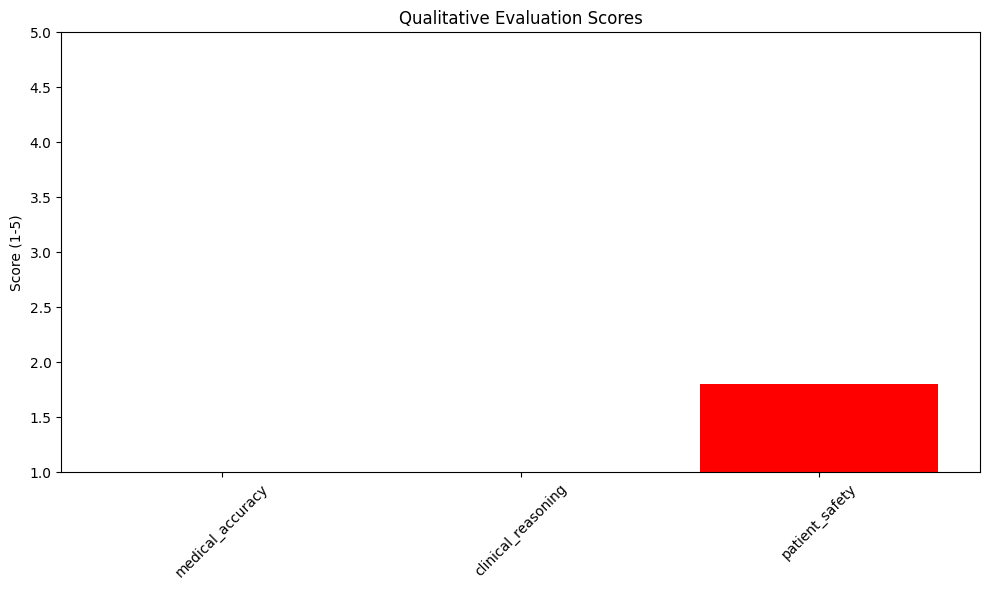

In [21]:
from datasets import load_dataset
from botocore.config import Config

with mlflow.start_run(run_name="example_model_evaluation"):
    # Get AWS credentials from the SageMaker execution environment
    retry_config = Config(
        retries={
            'max_attempts': 10,
            'mode': 'adaptive'  # or 'legacy', 'adaptive'
        }
    )
    session = boto3.Session()
    credentials = session.get_credentials()
    
    # Set as environment variables
    os.environ['AWS_ACCESS_KEY_ID'] = credentials.access_key
    os.environ['AWS_SECRET_ACCESS_KEY'] = credentials.secret_key
    if credentials.token:
        os.environ['AWS_SESSION_TOKEN'] = credentials.token
    
    # Set region - important for Bedrock
    region = boto3.session.Session().region_name
    os.environ['AWS_REGION'] = region

    mlflow.set_tag("component", "qualitative_model_evaluation")
    
    # Initialize the SageMaker client
    sm_client = boto3.client('sagemaker-runtime', config=retry_config)
    
    # Define the model to evaluate
    model_to_evaluate = {
        "name": f"Example-{model_name_safe}-sft-djl", 
        "endpoint": f"Example-{model_name_safe}-sft-djl"
        # "endpoint": endpoint_name
    }
    
    # Limit samples for faster execution
    num_samples = 10
    
    # Log evaluation parameters
    mlflow.log_param("qualitative_evaluation_endpoint", endpoint_name)
    mlflow.log_param("qualitative_evaluation_num_samples", num_samples)
    mlflow.log_param("qualitative_evaluation_timestamp", datetime.now().isoformat())
    mlflow.log_param("llm_judge_model", judge_llm)
    
    # Load the test dataset
    try:
        dataset = load_dataset("FreedomIntelligence/medical-o1-reasoning-SFT", "en", split="train")
        max_samples = len(dataset)
        dataset = dataset.shuffle().select(range(min(num_samples, max_samples)))
        print(f"Loaded medical-o1-reasoning dataset with {len(dataset)} samples for qualitative evaluation")
        
        mlflow.log_param("qualitative_dataset_name", "FreedomIntelligence/medical-o1-reasoning-SFT") 
        mlflow.log_param("qualitative_dataset_actual_samples", len(dataset))
    except Exception as e:
        error_msg = f"Error loading dataset for qualitative evaluation: {str(e)}"
        print(error_msg)
        raise
    
    try:
        # Perform qualitative evaluation
        qualitative_results = evaluate_model_qualitatively(model_to_evaluate, dataset)
        
        avg_medical_accuracy = qualitative_results["avg_medical_accuracy"]
        
        print(f"\nQualitative evaluation completed!")
        print(f"Average Medical Accuracy: {avg_medical_accuracy:.3f}")
        
        print(f"avg_medical_accuracy: {avg_medical_accuracy}")
        
    except Exception as e:
        error_msg = f"Error in qualitative model evaluation: {str(e)}\n{traceback.format_exc()}"
        print(error_msg)

### 6. Templating a Prompt

In the next workshop we fine-tune Qwen3-4B-Instruct-2507 to become a medical expert. To accomplish this, we execute a fine-tuning job using Managed MLflow on SageMaker AI. We get our data from the [FreedomIntelligence/medical-o1-reasoning-SFT](https://huggingface.co/datasets/FreedomIntelligence/medical-o1-reasoning-SFT) dataset, available on HuggingFace.

In this lab, we show a small example of what fine-tuning looks like for a single record of the dataset.

In [22]:
FINE_TUNING_DATA_SAMPLE = {
    "Question": "A 61-year-old woman with a long history of involuntary urine loss during activities like coughing or sneezing but no leakage at night undergoes a gynecological exam and Q-tip test. Based on these findings, what would cystometry most likely reveal about her residual volume and detrusor contractions?", 
    "Complex_CoT": "Okay, let's think about this step by step. There's a 61-year-old woman here who's been dealing with involuntary urine leakages whenever she's doing something that ups her abdominal pressure like coughing or sneezing. This sounds a lot like stress urinary incontinence to me. Now, it's interesting that she doesn't have any issues at night; she isn't experiencing leakage while sleeping. This likely means her bladder's ability to hold urine is fine when she isn't under physical stress. Hmm, that's a clue that we're dealing with something related to pressure rather than a bladder muscle problem.\n\nThe fact that she underwent a Q-tip test is intriguing too. This test is usually done to assess urethral mobility. In stress incontinence, a Q-tip might move significantly, showing urethral hypermobility. This kind of movement often means there's a weakness in the support structures that should help keep the urethra closed during increases in abdominal pressure. So, that's aligning well with stress incontinence.\n\nNow, let's think about what would happen during cystometry. Since stress incontinence isn't usually about sudden bladder contractions, I wouldn't expect to see involuntary detrusor contractions during this test. Her bladder isn't spasming or anything; it's more about the support structure failing under stress. Plus, she likely empties her bladder completely because stress incontinence doesn't typically involve incomplete emptying. So, her residual volume should be pretty normal.\n\nAll in all, it seems like if they do a cystometry on her, it will likely show a normal residual volume and no involuntary contractions. Yup, I think that makes sense given her symptoms and the typical presentations of stress urinary incontinence.",
    "Response": "Cystometry in this case of stress urinary incontinence would most likely reveal a normal post-void residual volume, as stress incontinence typically does not involve issues with bladder emptying. Additionally, since stress urinary incontinence is primarily related to physical exertion and not an overactive bladder, you would not expect to see any involuntary detrusor contractions during the test."
}

SYSTEM_PROMPT = """You are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning. 
Below is an instruction that describes a task, paired with an input that provides further context. 
Write a response that appropriately completes the request.
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response."""

def convert_to_messages(sample, system_prompt=""):
    
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": sample["Question"]},
        {"role": "assistant", 
         "content": 
         f"{sample["Complex_CoT"]}\n\n{sample["Response"]}"}
    ]

    sample["messages"] = messages
    
    return sample


PROCESSED_SAMPLE = convert_to_messages(FINE_TUNING_DATA_SAMPLE)
print(PROCESSED_SAMPLE)

{'Question': 'A 61-year-old woman with a long history of involuntary urine loss during activities like coughing or sneezing but no leakage at night undergoes a gynecological exam and Q-tip test. Based on these findings, what would cystometry most likely reveal about her residual volume and detrusor contractions?', 'Complex_CoT': "Okay, let's think about this step by step. There's a 61-year-old woman here who's been dealing with involuntary urine leakages whenever she's doing something that ups her abdominal pressure like coughing or sneezing. This sounds a lot like stress urinary incontinence to me. Now, it's interesting that she doesn't have any issues at night; she isn't experiencing leakage while sleeping. This likely means her bladder's ability to hold urine is fine when she isn't under physical stress. Hmm, that's a clue that we're dealing with something related to pressure rather than a bladder muscle problem.\n\nThe fact that she underwent a Q-tip test is intriguing too. This te

##### Fine-Tuning Output
The above output shows the templated prompt output to be used for fine-tuning. This pre-processing happens for every record in the fine-tuning dataset before fine-tuning actually takes place. This can be time-consuming for large fine-tuning datasets. We will show in the next lab how to orchestrate this with MLflow.

### Clean-up Endpoint

In [23]:
def delete_endpoint_with_retry(endpoint_name, max_retries=3, wait_seconds=10):
    """
    Delete a SageMaker endpoint with retry logic
    
    Args:
        endpoint_name (str): Name of the SageMaker endpoint to delete
        max_retries (int): Maximum number of retry attempts
        wait_seconds (int): Time to wait between retries in seconds
    
    Returns:
        bool: True if deletion was successful, False otherwise
    """
    sm_client = boto3.client('sagemaker')
    
    # First check if the endpoint exists
    try:
        sm_client.describe_endpoint(EndpointName=endpoint_name)
        endpoint_exists = True
    except botocore.exceptions.ClientError as e:
        if "Could not find endpoint" in str(e):
            print(f"Endpoint {endpoint_name} does not exist, no cleanup needed.")
            return True
        else:
            print(f"Error checking endpoint existence: {e}")
            return False
    
    # If we get here, the endpoint exists and we should delete it
    for attempt in range(max_retries):
        try:
            print(f"Attempting to delete endpoint {endpoint_name} (attempt {attempt + 1}/{max_retries})")
            sm_client.delete_endpoint(EndpointName=endpoint_name)
            sm_client.delete_endpoint_config(EndpointConfigName=endpoint_name)
            print(f"Endpoint {endpoint_name} deletion initiated successfully")
            
            # Wait for endpoint to be fully deleted
            print("Waiting for endpoint to be fully deleted...")
            
            # Poll until endpoint is deleted or max wait time is reached
            total_wait_time = 0
            max_wait_time = 300  # 5 minutes maximum wait
            while total_wait_time < max_wait_time:
                try:
                    sm_client.describe_endpoint(EndpointName=endpoint_name)
                    print(f"Endpoint still exists, waiting {wait_seconds} seconds...")
                    time.sleep(wait_seconds)
                    total_wait_time += wait_seconds
                except botocore.exceptions.ClientError:
                    print(f"Endpoint {endpoint_name} successfully deleted")
                    return True
            
            # If we get here, the endpoint still exists after max_wait_time
            print(f"Warning: Endpoint deletion initiated but still exists after {max_wait_time} seconds")
            return False
            
        except botocore.exceptions.ClientError as e:
            if "ResourceInUse" in str(e) or "ResourceNotFound" in str(e):
                print(f"Error deleting endpoint: {e}")
                print(f"Retrying in {wait_seconds} seconds...")
                time.sleep(wait_seconds)
            else:
                print(f"Unexpected error deleting endpoint: {e}")
                return False
    
    print(f"Failed to delete endpoint {endpoint_name} after {max_retries} attempts")
    return False

# Clean up endpoint
try:
    print(f"Cleaning up endpoint: {endpoint_name}")
    if delete_endpoint_with_retry(endpoint_name):
        print("Cleanup completed successfully")
    else:
        print("Warning: Endpoint cleanup may have failed, please check the SageMaker console")
        
except Exception as e:
    print(f"Error during endpoint cleanup: {str(e)}")
    print("You may need to manually delete the endpoint from the SageMaker console")

Cleaning up endpoint: Example-Qwen3-4B-Instruct-2507
Attempting to delete endpoint Example-Qwen3-4B-Instruct-2507 (attempt 1/3)
Endpoint Example-Qwen3-4B-Instruct-2507 deletion initiated successfully
Waiting for endpoint to be fully deleted...
Endpoint still exists, waiting 10 seconds...
Endpoint Example-Qwen3-4B-Instruct-2507 successfully deleted
Cleanup completed successfully


### Next Steps
In this notebook, we illustrated the building blocks for a fine-tuned LLM-deployment pipeline. We showed:

1. How to prepare data for a fine-tuning job
2. How to deploy a model to a SageMaker AI Managed Endpoint
3. How to evaluate a model's performance
4. Creating and applying Guardrails to our model
5. Tracing model calls using MLFlow tracing

Next, we show how to actually perform fine-tuning on this Qwen3 model to improve the model's performance in this domain. Moreover, we'll orchestrate all of these steps into a fine-tuning pipeline powered by Managed MLFlow and SageMaker AI Pipelines.